<a href="https://colab.research.google.com/github/GarzonDiegoINL/Characterization/blob/main/Tauc_Plot_UVVis_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tauc Plot**

To calculate the band gap of your thin film from the data of transmittance with the IS.

Here you can find more about the theory here: [Determine band gap of semiconductors](https://pubs.acs.org/doi/10.1021/acs.jpclett.8b02892), [Wikipedia page](https://en.wikipedia.org/wiki/Tauc_plot), [Revisiting the optical bandgap of semiconductors and the proposal of a unified methodology to its determination](https://www.nature.com/articles/s41598-019-47670-y)

In this case, the absorption coefficient is calculated from the transmittance data and the thickness, following the formula:

\begin{align}
  \alpha = +\frac{1}{t} \cdot \ \ln\left(\frac{(1-R)^2}{T} + \sqrt{\frac{(1-R)^4}{4T^2}+R^2}\right)
\end{align}


Where $\alpha$ is the absorption coefficient, $t$ is the thickness of the film in cm. $T$ and $R$ is the transmittance and reflectance fraction, respectively. This data is obtained directly from the csv file.

In addition, in order to calculate the energy in eV ($h\nu$), the following formula is used based on the wavelenght ($\lambda$) measured:

\begin{align}
 h\nu = \frac{hc}{\lambda} \cdot \frac{1}{e}
\end{align}

Where $h$ is Plank's constant, $c$ is the speed of light, and $e$ is the elemental charge.

Following the tauc method, the following mathematical relation will be used:

\begin{align}
 (h\nu \cdot \alpha)^{1/\gamma} = B(h\nu - E_g)
\end{align}

Where $\gamma$ denotes the nature of the transitions, in this code we  only considered $\gamma = 2$ and $\gamma = 1/2$ for indirect and direct allowed transitions, respectively. $E_g$ corresponds to the band gap and it is found by extrapolating to the abscissa the linear region in the plot.

# **Instruction to run the code**

In order to run the code you have to continue with the following steps:

1.   Create and excel file called "thickness.xlsx" with two columns, the first column should be called Ref and should correspond to the name of the csv files (with out the .csv), and the second colum should be called thickness and should correspond to the thickness of your thin film in cm. For example:

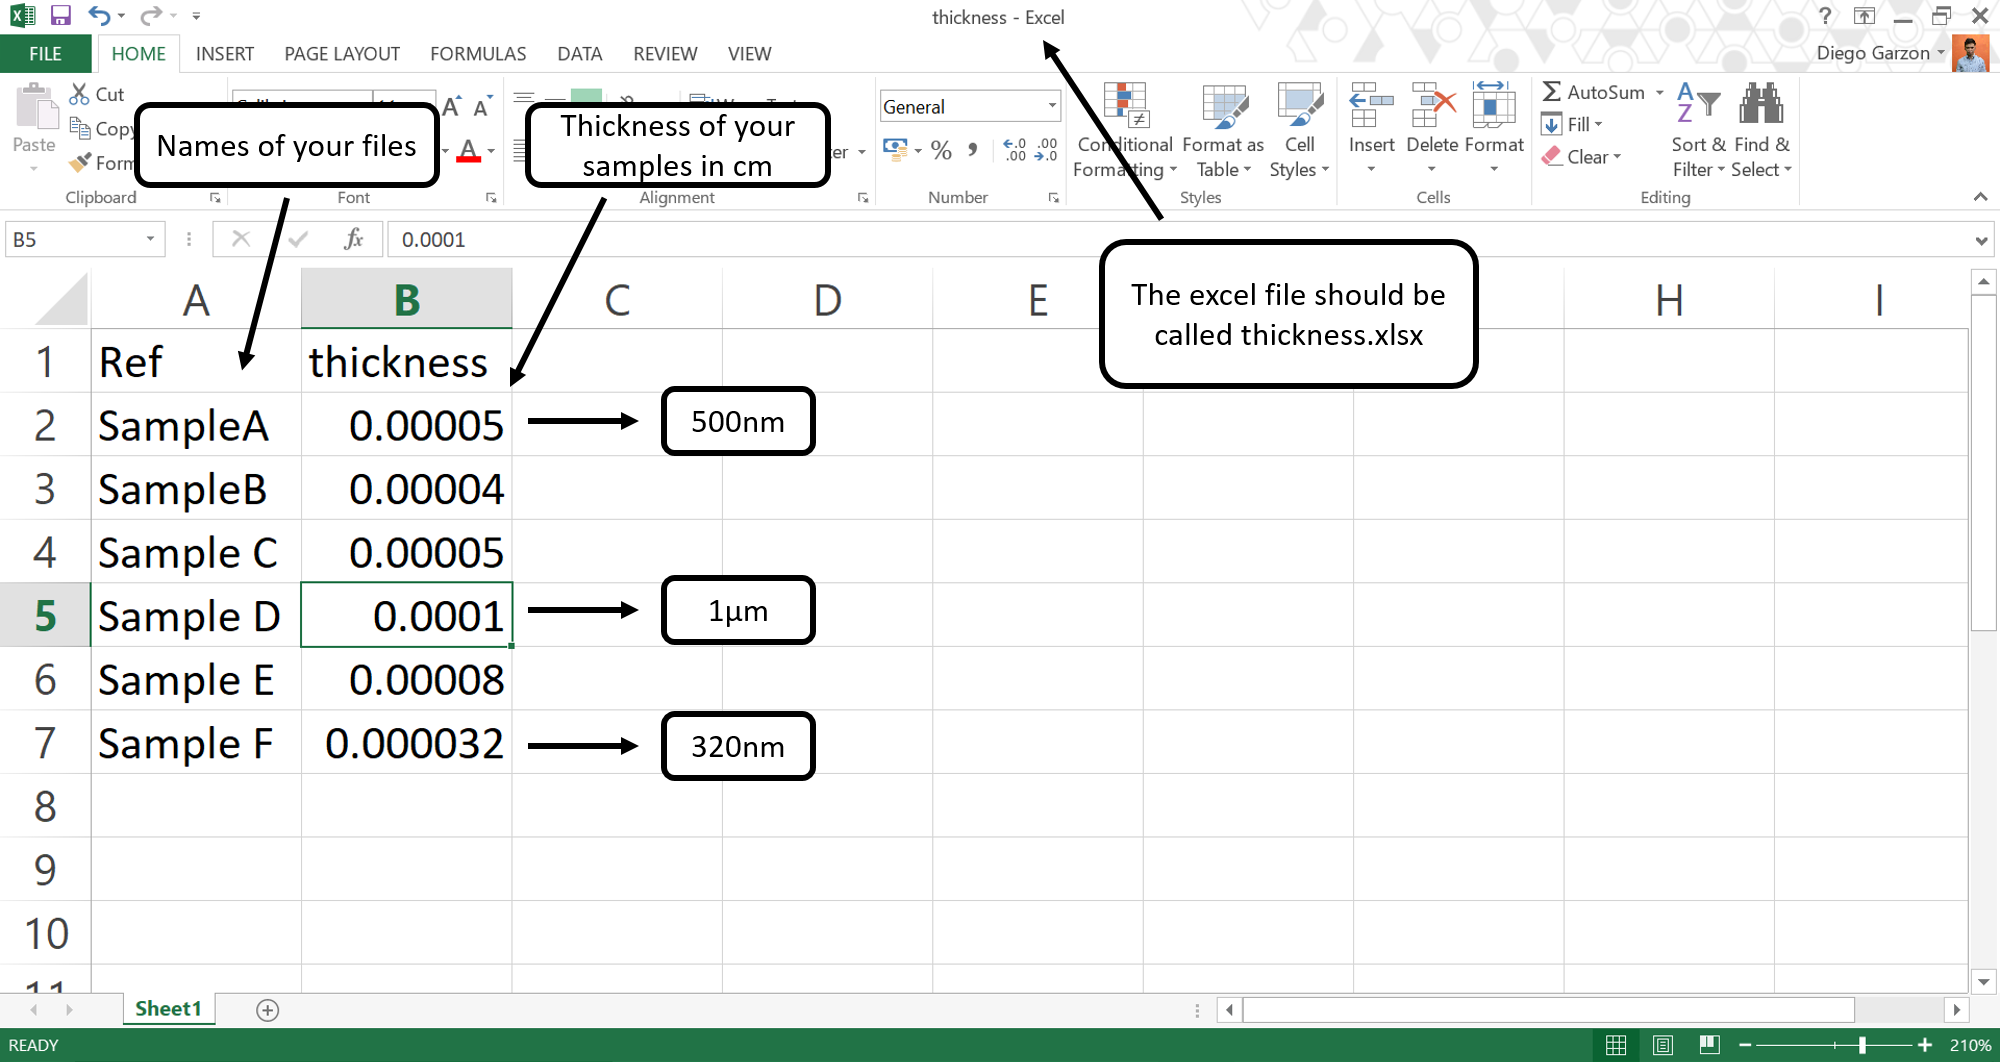

2.   Upload the thickness.xlsx file together with the csv files that you got from your transmmitance measurement. In order to upload, click the folder button in the left of the screen and click the upload button (first button), and select the respective files files. It is important to have the transmittance file with the name **"T-Sample name"** and the reflectance file with the name **"R-Sample name"**. For example:

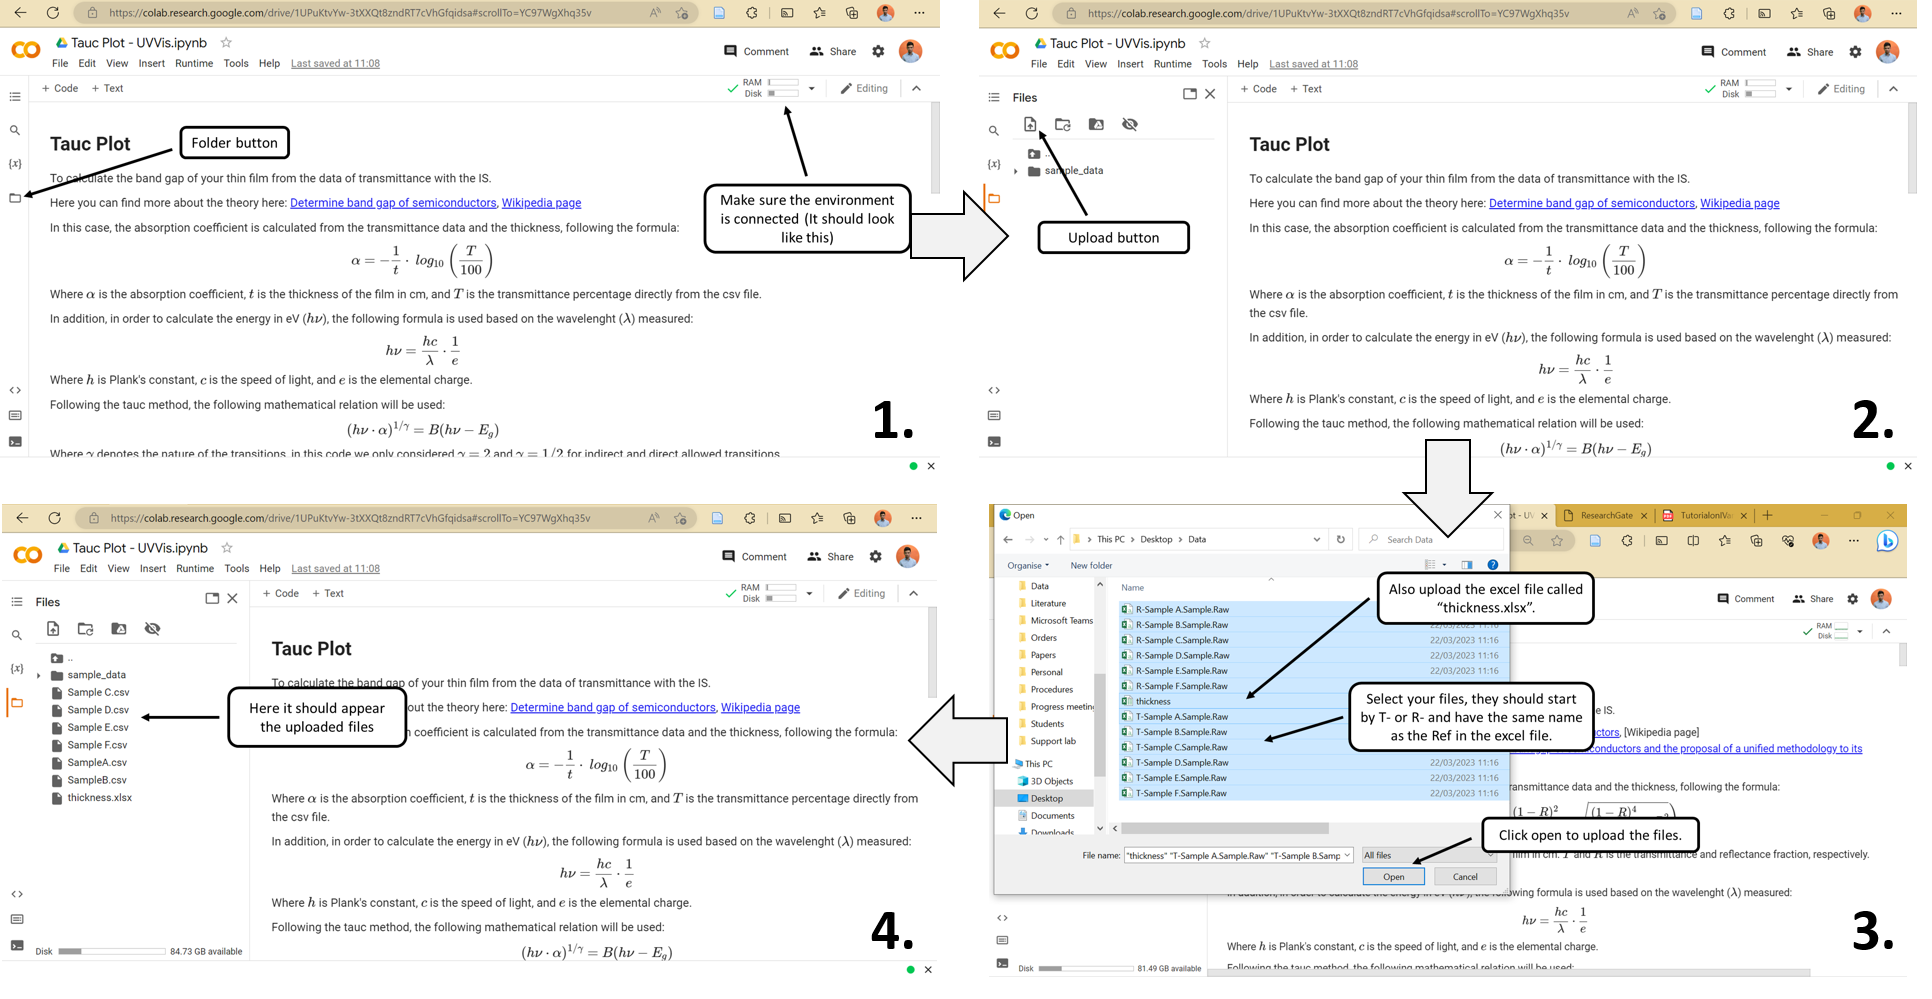

3. Run the following cells that will produce the tauc plots. To run the cells, select them and click Ctrl+Enter or the play button in the left of the cell. You can also click Ctrl+F9 to run all.

In [ ]:
#Required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import glob as gl

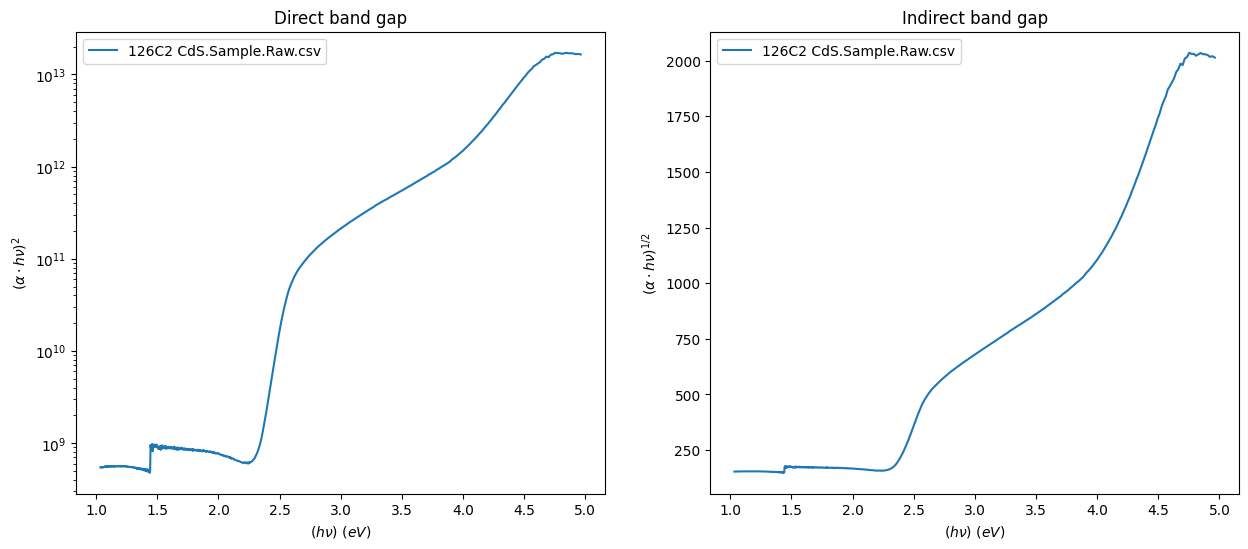

In [ ]:
#Read the excel file to obtain the thickness
sample = pd.read_excel('/content/thickness.xlsx')
sample['Ref'] = sample['Ref']
sample = sample.set_index('Ref')
sample = sample.to_dict()['thickness']

#Read the csv files
files = gl.glob('*.csv')
files = [x for x in files if 'T-' in x]

#DataFrame to save the results
results1 = pd.DataFrame()
results2 = pd.DataFrame()
results3 = pd.DataFrame()

#Dictionary to save the results
res = {}

#Create the Tauc plots for all the samples
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

#For each row in the excel file, it will look for the csv file with that name and calculate the respective alpha, and the quantities for the tauc plots
for file in files:
  label = file.split('-')[-1]
  if '.Sample.Raw.' in label:
    thickness = sample[label.split('.Sample.Raw.csv')[0]]
  else:
    thickness = sample[label.split('.csv')[0]]
  if thickness != 0:
    label = file.split('-')[-1]
    data_ = pd.read_csv('T-' + label)
    data_ = data_.join(pd.read_csv('R-' + label)[' %R'])
    data_[' %R_'] = data_[' %R']/100
    data_[' %T_'] = data_[' %T']/100
    nm = data_['nm']
    rt = (1 - data_[' %R_'])**2/(data_[' %T_']) + np.sqrt( (1 - data_[' %R_'])**4/(4*data_[' %T_']**2) +  data_[' %R_']**2  )
    #data = np.loadtxt(file,skiprows=1, delimiter=',')

    x = (6.626*10**-34 * 3*10**8)/ (nm * 10**-9) / (1.60217*10**(-19))
    data_y = np.where(rt <= 0, 1E-10, rt)

    y = np.log(data_y)/thickness
    y_DA = (y*x)**(2)
    y_IA = (y*x)**(1/2)

    try:
      results1['photon_energy_' + label] = x
      results1['nm' + label] = data_['nm']
      results1['DA_ahv^2_' + label] = y_DA
      results1['DA_ahv^0.5_' + label] = y_IA
      results1['%R' + label] = data_[' %R']
      results1['%T' + label] = data_[' %T']
      results1['alpha' +  label] = y
    except Exception as e:
      try :
        #print(e)
        results2['photon_energy_' + label] = x
        results2['DA_ahv^2_' + label] = y_DA
        results2['DA_ahv^0.5_' + label] = y_IA
      except Exception as e:
        results3['photon_energy_' + label] = x
        results3['DA_ahv^2_' + label] = y_DA
        results3['DA_ahv^0.5_' + label] = y_IA

    res[label] = {'hv':x, 'DA':np.nan_to_num(y_DA), 'IA':np.nan_to_num(y_IA)}

    #Plot the data
    ax1.plot(x,y_DA, label=label)
    ax2.plot(x,y_IA, label=label)


#Fix the graph of direct band gap
ax1.legend()
ax1.set_ylabel(r'$(\alpha \cdot h \nu)^2$')
ax1.set_xlabel(r'$(h \nu) \ (eV)$')
ax1.set_title('Direct band gap')
ax1.set_yscale("log")

#Fix the graph of indirect band gap
ax2.legend()
ax2.set_ylabel(r'$(\alpha \cdot h \nu)^{1/2}$')
ax2.set_xlabel(r'$ ( h \nu) \ (eV)$')
ax2.set_title('Indirect band gap')

#Save the values of the tauc plot in excel files
results1.to_excel('results1 tauc plots.xlsx')
results2.to_excel('results2 tauc plots.xlsx')
results3.to_excel('results3 tauc plots.xlsx')

plt.show()

27436712197287.69
1756.4190965393186


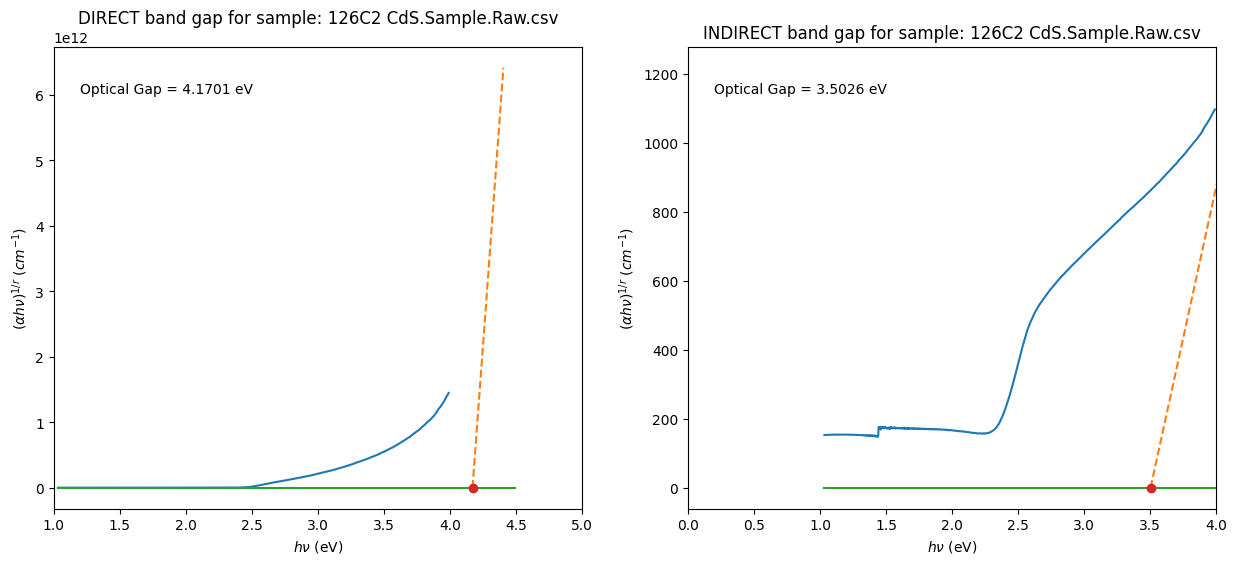

In [ ]:
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

gaps = []
for k in res.keys():

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

        #If you think you are seeing the band gap of the substrate (glass or FTO)
        #with a bandgap around 3.5-4, you can modify this parameter here called max_value
        max_value = 4.5


        # Calculate Tauc plots
        tauc_spectrum = np.zeros((len(res[k]['hv'][res[k]['hv']<max_value]),3))
        x_tot = res[k]['hv'][res[k]['hv']<4]
        tauc_spectrum[:,0] = res[k]['hv'][res[k]['hv']<max_value]
        tauc_spectrum[:,1] = res[k]['DA'][res[k]['hv']<max_value]
        tauc_spectrum[:,2] = res[k]['IA'][res[k]['hv']<max_value]

        for y_data, ax, tit, y_tot in zip([tauc_spectrum[:,1], tauc_spectrum[:,2]],
                                          (ax1, ax2), ('DIRECT band gap for sample: ' + k, 'INDIRECT band gap for sample: ' + k ),
                                          [res[k]['DA'][res[k]['hv']<4], res[k]['IA'][res[k]['hv']<4]]):
          # Transform Tauc plot to interpolation function
          y = interp1d(tauc_spectrum[:,0], savgol_filter(y_data, 51, 3))
          x = np.linspace(tauc_spectrum[0,0], tauc_spectrum[-1,0], 5000)

          # Calculate 1st derivative along Tauc plot
          dy = np.diff(y(x), 1, 0)
          dx = np.diff(x, 1, 0)
          y_1d = interp1d(x[:-1], dy/dx)

          # Calculate 2nd derivative along Tauc plot
          d2y = np.diff(y(x), 2, 0)
          dx2 = 0.0001
          y_2d = interp1d(x[:-2], d2y/dx2)

          # Find point in Tauc plot where 2nd derivative == 0 and gradient is at a maximum
          gradmax = 0.

          for i in range(2, len(x[:-2])):
              grad = y_1d(x[:-2])[i]
              if grad > gradmax:
                  gradmax = grad
              if np.allclose([y_2d(x[:-2])[i]], [0.], atol=0.001) and y(x)[i] > 0.1*np.amax(y_data) and grad >= gradmax:# and x[:-2][i]<3.5:
                  x_0 = x[i]
                  y_0 = y(x)[i]

          # Calculate extrapolation line
          m = y_1d(x_0)
          c = y_0 - m*x_0

          # Calculate optical gap from extrapolation line
          x_cross = (0 - c)/m
          gap = x_cross

          #gaps.append([spectrum_file, x_cross])

          # Plot Tauc plot, extrapolation line and point equal to optical gap
          ax.set_xlabel(r'$ h \nu$ (eV)')
          ax.set_ylabel(r'$( \alpha h \nu )^{1/r}$ $(cm^{-1})$')
          ax.text(0.05, 0.9, 'Optical Gap = '+str(x_cross)[:6]+' eV', transform=ax.transAxes)
          ax.set_xlim(1,5)

          gaps.append([k,x_cross])

          ax.plot(x_tot, y_tot,'-',
                  [(0-c)/m, (0.7*np.amax(y_data)-c)/m], [0, 0.7*np.amax(y_data)], '--',
                  tauc_spectrum[:,0], np.zeros(len(tauc_spectrum)), '-',
                  x_cross, 0, 'o', )
          ax.plot()

          ax.set_title(tit)
          print(m)
        plt.xlim([0,4])
        plt.savefig('Tauc plot for sample: ' + k + '.png')
        plt.show()
        #plt.close()

4. Write down the values for the bandgap, you can also download the graphs and the data. The data for making the tauc plots will be save in files called "results_.xlsx" and the graphs will be saved in files called "Tauc plot for sample: __.png"